## Classification with Python

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-12-29 19:52:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2020-12-29 19:52:46 (305 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install seaborn

Solving environment: done

# All requested packages already installed.



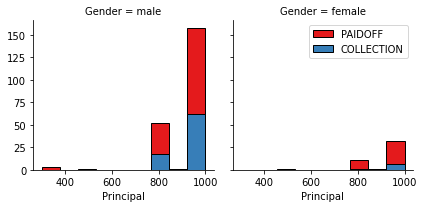

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

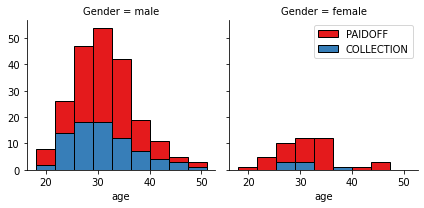

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

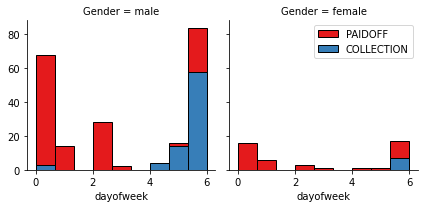

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## Splitting of train and test data

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


## Finding of best K for KNN classifier

[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286]


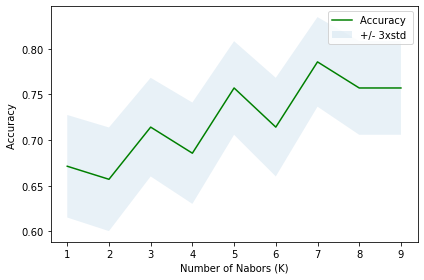

The best accuracy was with 0.7857 with k= 7


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)


plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with %.4f" % mean_acc.max(), "with k=", mean_acc.argmax()+1)

## Accuracy evaluation

In [22]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

# Train Model and Predict
k = 7

neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

yhat = neigh.predict(X_test)

print("Train set Accuracy: %.4f" % metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: %.4f" % metrics.accuracy_score(y_test, yhat))

print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(y_test, yhat, pos_label = "PAIDOFF"))

Train set Accuracy: 0.8080
Test set Accuracy: 0.7857
Avg F1-score: 0.7767
jaccard_score: 0.7656


# Decision Tree

## Splitting of train and test data

In [23]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))
print('Shape of X training set {}'.format(X_testset.shape),'&',' Size of Y training set {}'.format(y_testset.shape))

Shape of X training set (242, 8) &  Size of Y training set (242,)
Shape of X training set (104, 8) &  Size of Y training set (104,)


In [24]:
from sklearn.tree import DecisionTreeClassifier

PayTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
print(PayTree) # it shows the default parameters
PayTree.fit(X_trainset,y_trainset)

predTree = PayTree.predict(X_testset)

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

print("Avg F1-score: %.4f" % f1_score(y_testset, predTree, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(y_testset, predTree, pos_label="PAIDOFF"))

DecisionTreeClassifier(criterion='entropy', max_depth=6)
DecisionTrees's Accuracy:  0.7019230769230769
Avg F1-score: 0.7001
jaccard_score: 0.6667


Solving environment: done

# All requested packages already installed.



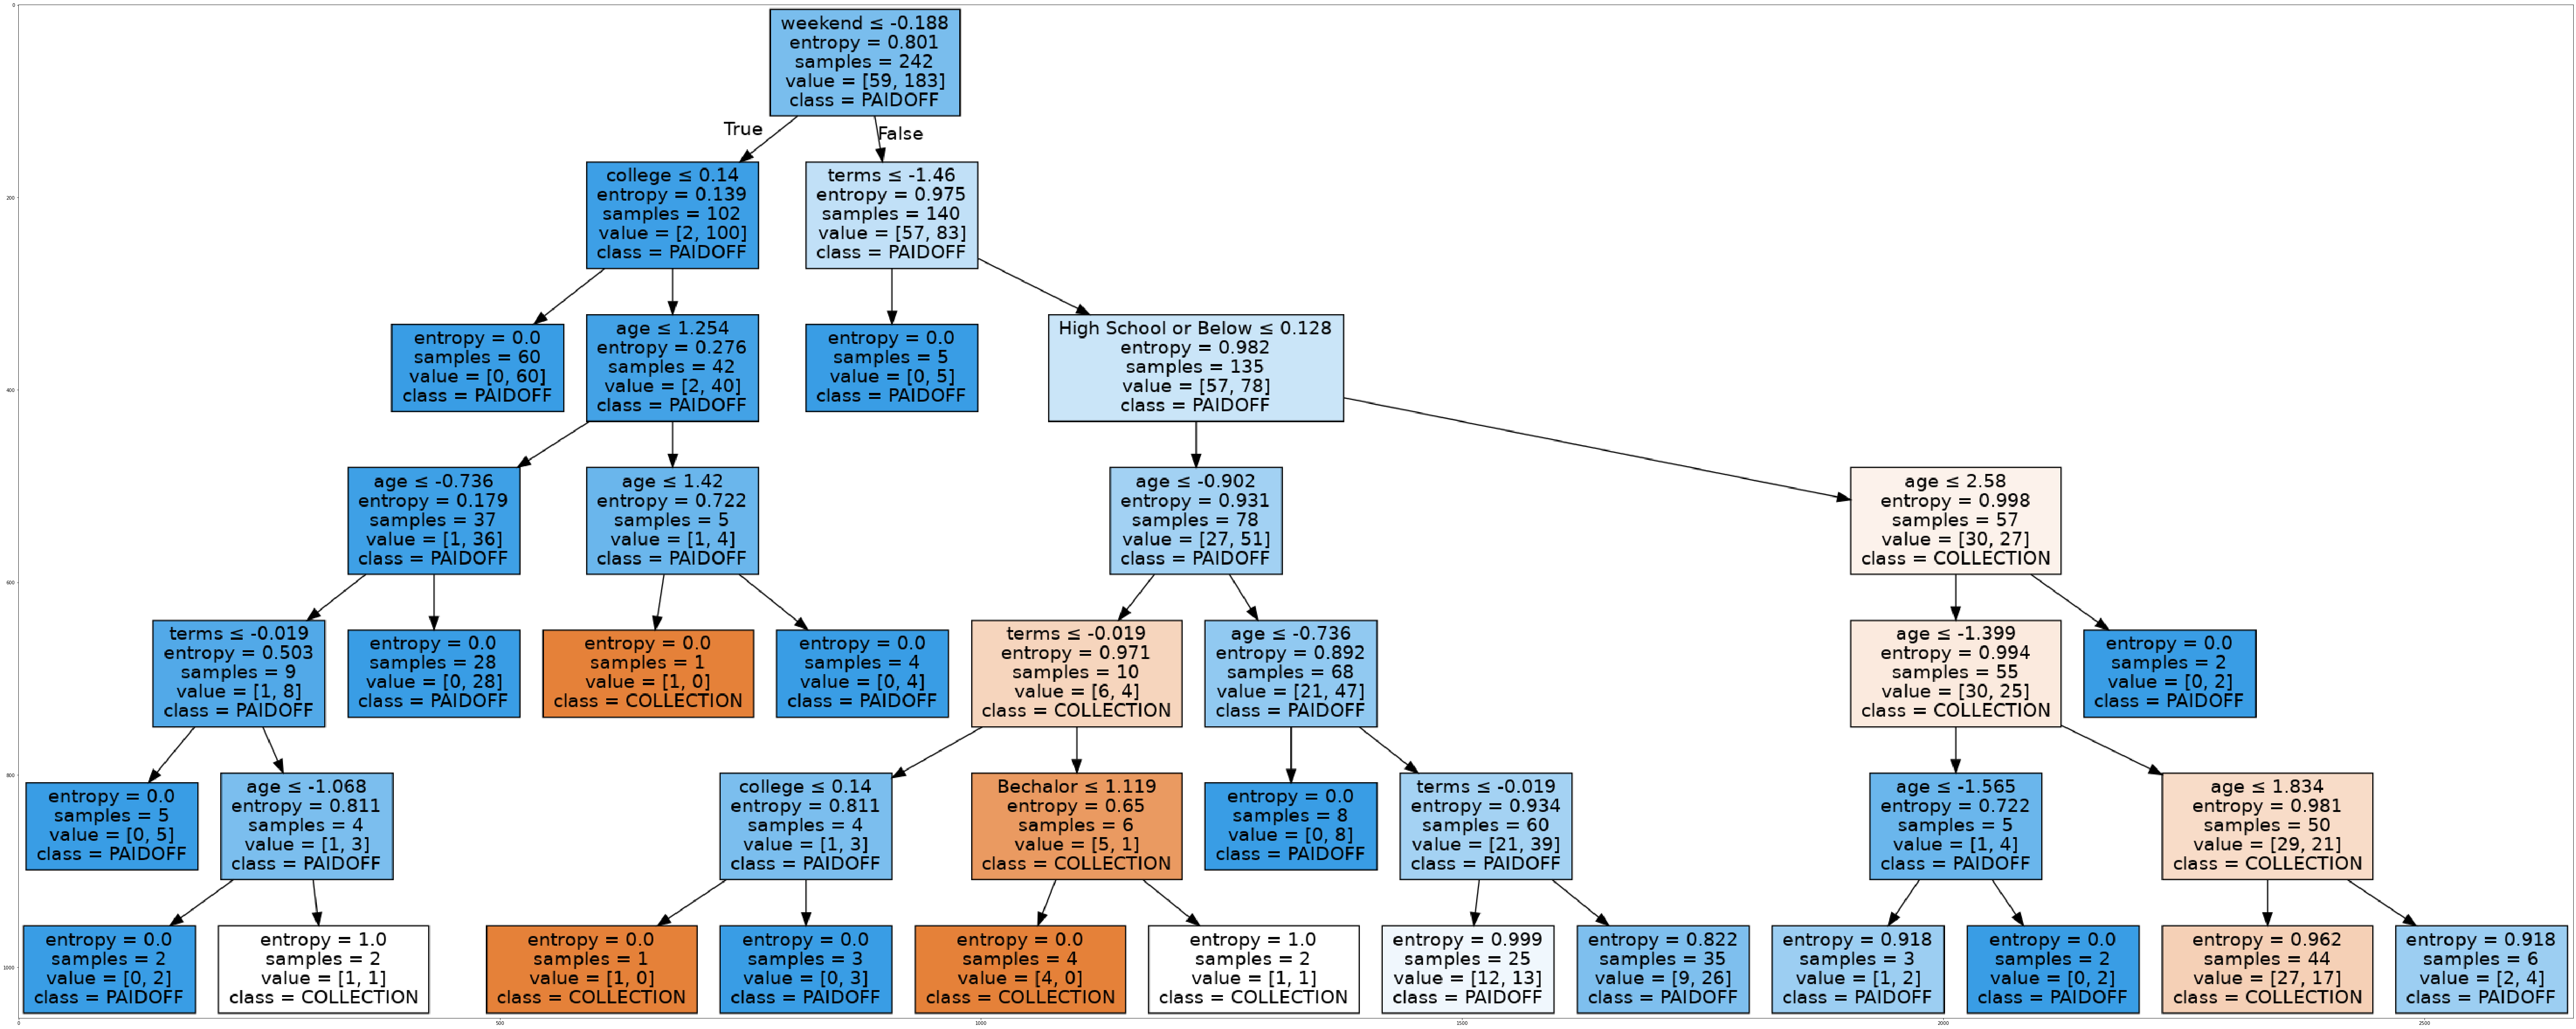

In [25]:
!conda install pydotplus

from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

dot_data = StringIO()
filename = "PayTree.png"
featureNames = Feature.columns[0:]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(PayTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

## Splitting of train and test data

In [26]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


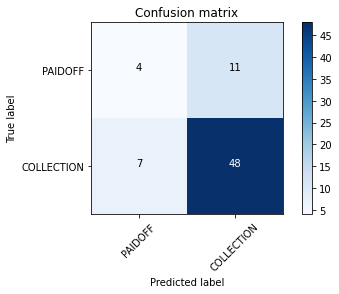

Avg F1-score: 0.7276
jaccard_score: 0.7273


In [27]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

yhat = clf.predict(X_test)
print(yhat[0:5])

from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')
plt.show()

print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(y_test, yhat, pos_label="PAIDOFF"))

In [28]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)

print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(y_test, yhat2, pos_label="PAIDOFF"))

Avg F1-score: 0.6914
jaccard_score: 0.7857


# Logistic Regression

## Splitting of train and test data

In [29]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


LogisticRegression(C=0.01, solver='liblinear')
[[ 2 13]
 [ 9 46]]
Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


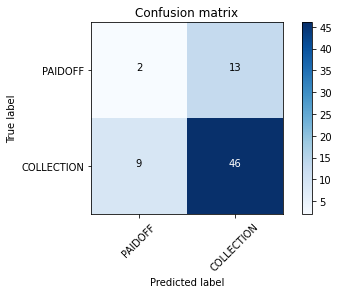

              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



In [30]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
print(LR)

yhat = LR.predict(X_test)
yhat[0:5]

yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:5]

print(confusion_matrix(y_test, yhat))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')
plt.show()

print (classification_report(y_test, yhat))

In [31]:
from sklearn.metrics import log_loss

print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(y_test, yhat, pos_label="PAIDOFF"))
print("LogLoss: %.4f" % log_loss(y_test, yhat_prob))

Avg F1-score: 0.6671
jaccard_score: 0.6765
LogLoss: 0.5772


In [32]:
LR2 = LogisticRegression(C=0.05, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss: %.4f" % log_loss(y_test, yhat_prob2))

LogLoss: 0.4805


# Model Evaluation using Test set

In [33]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline


# from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [34]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-12-29 19:53:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-12-29 19:53:23 (77.8 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [35]:
test_df = pd.read_csv('loan_test.csv')
print(test_df.shape)
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
print(test_df.head())
test_df['loan_status'].value_counts()

(54, 10)
   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30     2016-09-08   
1           5             5     PAIDOFF        300      7     2016-09-09   
2          21            21     PAIDOFF       1000     30     2016-09-10   
3          24            24     PAIDOFF       1000     30     2016-09-10   
4          35            35     PAIDOFF        800     15     2016-09-11   

    due_date  age             education  Gender  
0 2016-10-07   50              Bechalor  female  
1 2016-09-15   35       Master or Above    male  
2 2016-10-09   43  High School or Below  female  
3 2016-10-09   26               college    male  
4 2016-09-25   29              Bechalor    male  


PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

## Vizualization of data relationship

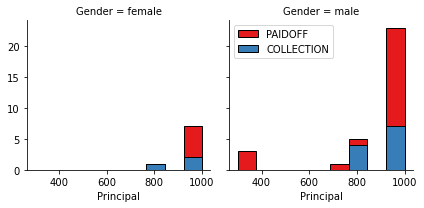

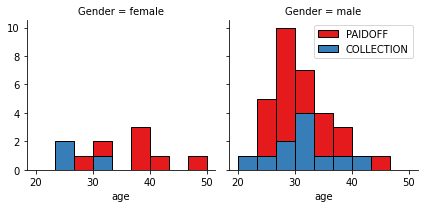

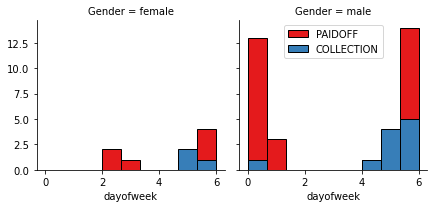

In [36]:
import seaborn as sns

bins = np.linspace(test_df.Principal.min(), test_df.Principal.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

bins = np.linspace(test_df.age.min(), test_df.age.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

## Pre-processing: Feature selection/extraction

In [37]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [38]:
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_Feature = pd.concat([Test_Feature,pd.get_dummies(test_df['education'])], axis=1)
Test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
Test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [39]:
Test_X = Test_Feature
Test_X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [40]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data

In [41]:
Test_X = preprocessing.StandardScaler().fit(Test_X).transform(Test_X)
type(Test_X)
Test_X[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

## Classification
## 1. K Nearest Neighbor(KNN)

In [42]:
yhat_test = neigh.predict(Test_X)

print("Train set Accuracy: %.4f" % metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: %.4f" % metrics.accuracy_score(test_y, yhat_test))

print("Avg F1-score: %.4f" % f1_score(test_y, yhat_test, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(test_y, yhat_test, pos_label="PAIDOFF"))

Train set Accuracy: 0.8080
Test set Accuracy: 0.6667
Avg F1-score: 0.6328
jaccard_score: 0.6538


## Decision Tree

In [43]:
Test_predTree = PayTree.predict(Test_X)

# print (Test_predTree [0:5])
# print (test_y [0:5])

print("DecisionTrees's Accuracy: %.4f" % metrics.accuracy_score(test_y, Test_predTree))
print("Avg F1-score: %.4f" % f1_score(test_y, Test_predTree, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(test_y, Test_predTree, pos_label="PAIDOFF"))

DecisionTrees's Accuracy: 0.7963
Avg F1-score: 0.7938
jaccard_score: 0.7609


## Support Vector Machine

In [44]:
yhat_test = clf.predict(Test_X)
# print(yhat_test[0:5])
# print (test_y [0:5])
print("Avg F1-score: %.4f" % f1_score(test_y, yhat_test, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(test_y, yhat_test, pos_label="PAIDOFF"))

Avg F1-score: 0.7584
jaccard_score: 0.7800


## Logistic regression

[[ 1 13]
 [ 1 39]]
Confusion matrix, without normalization
[[ 1 13]
 [ 1 39]]


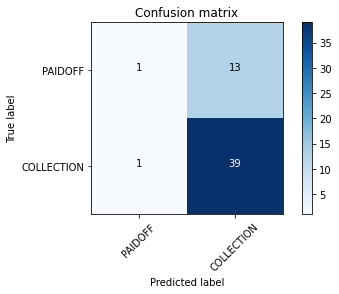

              precision    recall  f1-score   support

  COLLECTION       0.50      0.07      0.12        14
     PAIDOFF       0.75      0.97      0.85        40

    accuracy                           0.74        54
   macro avg       0.62      0.52      0.49        54
weighted avg       0.69      0.74      0.66        54



In [45]:
yhat_test = LR.predict(Test_X)

yhat_test_prob = LR.predict_proba(Test_X)

print(confusion_matrix(test_y, yhat_test))

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, yhat_test)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')
plt.show()

print (classification_report(test_y, yhat_test))

In [46]:
print("Avg F1-score: %.4f" % f1_score(test_y, yhat_test, average='weighted'))
print("jaccard_score: %.4f" % jaccard_score(test_y, yhat_test, pos_label="PAIDOFF"))
print("LogLoss: %.4f" % log_loss(test_y, yhat_test_prob))

Avg F1-score: 0.6604
jaccard_score: 0.7358
LogLoss: 0.5672


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.6538  | 0.6328   | NA      |
| Decision Tree      | 0.7609  | 0.7938   | NA      |
| SVM                | 0.7800  | 0.7584   | NA      |
| LogisticRegression | 0.7358  | 0.6604   | 0.5672  |